In [ ]:
import os
import csv
import git
from pydriller import Repository

repos = [
    "https://github.com/lumc/pytest-workflow",
    "https://github.com/robotcodedev/robotcode",
    "https://github.com/tsfpga/tsfpga"
]


BASE_DIR = "./cloned_repos"
os.makedirs(BASE_DIR, exist_ok=True)


OUTPUT_CSV = "pydriller_dataset.csv"


headers = [
    "old_file_path", "new_file_path",
    "commit_SHA", "parent_commit_SHA",
    "commit_message",
    "diff_myers1", "diff_hist2"
]

with open(OUTPUT_CSV, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    for repo_url in repos:
        repo_name = repo_url.split("/")[-1]
        repo_path = os.path.join(BASE_DIR, repo_name)

        
        if not os.path.exists(repo_path):
            print(f"Cloning {repo_url} ...")
            git.Repo.clone_from(repo_url, repo_path)

        print(f"Processing {repo_name} ...")
        git_repo = git.Repo(repo_path)

        # Traverse commits with PyDriller
        for commit in Repository(repo_path).traverse_commits():
            if not commit.parents:
                continue  # skip root commits (no parent)

            parent_sha = commit.parents[0]

            for mod in commit.modified_files:   # PyDriller 2.6
                if mod.diff is None:   # skip empty or binary changes
                    continue

                try:
                    file_path = mod.new_path if mod.new_path else mod.old_path

                    # Myers diff (fast, from PyDriller)
                    diff_myers = mod.diff

                    # Histogram diff (via GitPython)
                    diff_hist = git_repo.git.diff(
                        parent_sha, commit.hash,
                        "--", file_path,
                        diff_algorithm="histogram"
                    )

                    writer.writerow({
                        "old_file_path": mod.old_path,
                        "new_file_path": mod.new_path,
                        "commit_SHA": commit.hash,
                        "parent_commit_SHA": parent_sha,
                        "commit_message": commit.msg.strip(),
                        "diff_myers1": diff_myers,
                        "diff_hist2": diff_hist
                    })
                except Exception as e:
                    print(f" Error in commit {commit.hash} ({repo_name}): {e}")

print(f"\n Dataset saved to {OUTPUT_CSV}")


Processing pytest-workflow ...
Processing robotcode ...
Cloning https://github.com/tsfpga/tsfpga ...
Processing tsfpga ...

✅ Dataset saved to pydriller_dataset.csv


In [ ]:
import pandas as pd

def normalize_diff(diff_text: str):
    if not isinstance(diff_text, str):
        return []

    lines = []
    for line in diff_text.splitlines():
        if line.startswith(("+++", "---", "index", "diff", "@@")):
            continue  # skip metadata
        if line.startswith("+") or line.startswith("-"):
            lines.append(line.strip())
    return lines

def compare_diffs(diff_myers: str, diff_hist: str) -> str:
    
    norm_myers = normalize_diff(diff_myers)
    norm_hist = normalize_diff(diff_hist)

    if not norm_myers and not norm_hist:
        return "No"   # both empty, no discrepancy

    return "No" if norm_myers == norm_hist else "Yes"



input_csv = "pydriller_dataset.csv"
output_csv = "pydriller_dataset_with_discrepancy.csv"

df = pd.read_csv(input_csv)


df["Discrepancy"] = df.apply(
    lambda row: compare_diffs(row["diff_myers1"], row["diff_hist2"]),
    axis=1
)

df.to_csv(output_csv, index=False, encoding="utf-8")

print(f" Final dataset saved to {output_csv}")


✅ Final dataset saved to pydriller_dataset_with_discrepancy.csv


Mismatch Report:
Source Code: 1073
Test Code: 4545
README: 13
LICENSE: 2


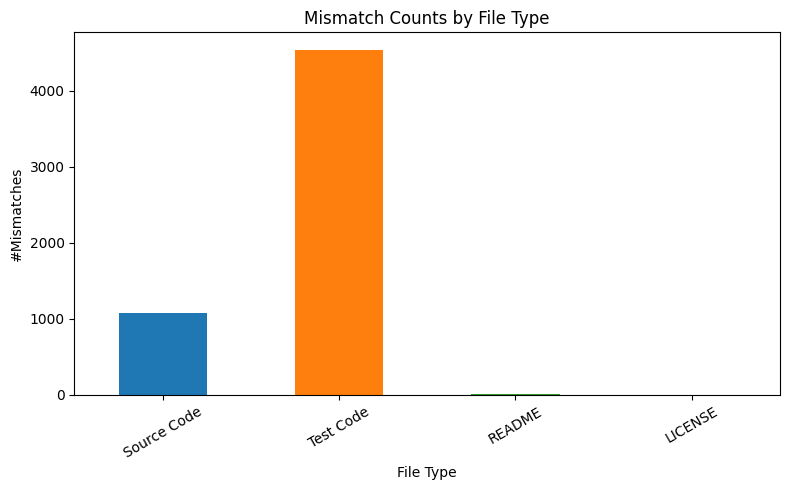

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os


input_csv = "pydriller_dataset_with_discrepancy.csv"
df = pd.read_csv(input_csv)


def classify_file(row):
    path = str(row["new_file_path"] if pd.notna(row["new_file_path"]) else row["old_file_path"])
    path_lower = path.lower()

    if path == "nan" or path.strip() == "":
        return "Other"

    filename = os.path.basename(path)

    if filename.lower().startswith("readme"):
        return "README"
    if filename.lower().startswith("license"):
        return "LICENSE"
    if "test" in path_lower or "tests" in path_lower:
        return "Test Code"
    if filename.endswith((".py", ".c", ".cpp", ".java", ".js", ".ts", ".rb", ".go", ".rs")):
        return "Source Code"
    return "Other"


df["FileType"] = df.apply(classify_file, axis=1)


mismatches = df[df["Discrepancy"] == "Yes"]


counts = mismatches["FileType"].value_counts()


print("Mismatch Report:")
for category in ["Source Code", "Test Code", "README", "LICENSE"]:
    print(f"{category}: {counts.get(category, 0)}")

plt.figure(figsize=(8,5))
counts = counts.reindex(["Source Code", "Test Code", "README", "LICENSE"], fill_value=0)
counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])

plt.title("Mismatch Counts by File Type")
plt.xlabel("File Type")
plt.ylabel("#Mismatches")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


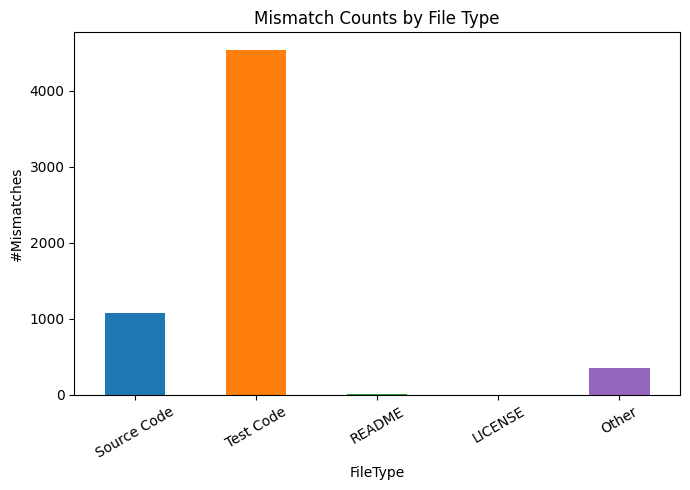

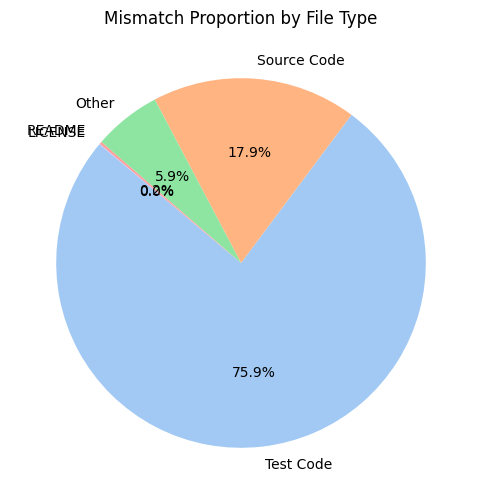

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


input_csv = "pydriller_dataset_with_discrepancy.csv"
df = pd.read_csv(input_csv)


def classify_file(row):
    path = str(row["new_file_path"] if pd.notna(row["new_file_path"]) else row["old_file_path"])
    path_lower = path.lower()
    filename = os.path.basename(path)

    if filename.lower().startswith("readme"):
        return "README"
    if filename.lower().startswith("license"):
        return "LICENSE"
    if "test" in path_lower or "tests" in path_lower:
        return "Test Code"
    if filename.endswith((".py", ".c", ".cpp", ".java", ".js", ".ts", ".rb", ".go", ".rs")):
        return "Source Code"
    return "Other"

df["FileType"] = df.apply(classify_file, axis=1)


mismatches = df[df["Discrepancy"] == "Yes"]


counts = mismatches["FileType"].value_counts().reindex(
    ["Source Code", "Test Code", "README", "LICENSE", "Other"], fill_value=0
)
plt.figure(figsize=(7,5))
counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.title("Mismatch Counts by File Type")
plt.ylabel("#Mismatches")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,6))
counts = mismatches["FileType"].value_counts()
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("pastel"))
plt.title("Mismatch Proportion by File Type")
plt.show()


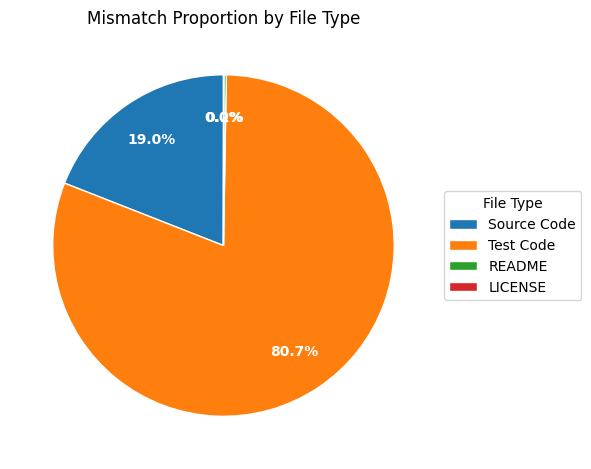

In [ ]:
import matplotlib.pyplot as plt


counts = {
    "Source Code": 1073,
    "Test Code": 4545,
    "README": 13,
    "LICENSE": 2
}

labels = list(counts.keys())
sizes = list(counts.values())


fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'},
    pctdistance=0.75
)


ax.legend(
    wedges,
    labels,
    title="File Type",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)


plt.setp(autotexts, size=10, weight="bold", color="white")

ax.set_title("Mismatch Proportion by File Type")
plt.tight_layout()
plt.show()


Mismatch Report:
Source Code: 1073
Test Code: 4545
README: 13
LICENSE: 2
Other: 354


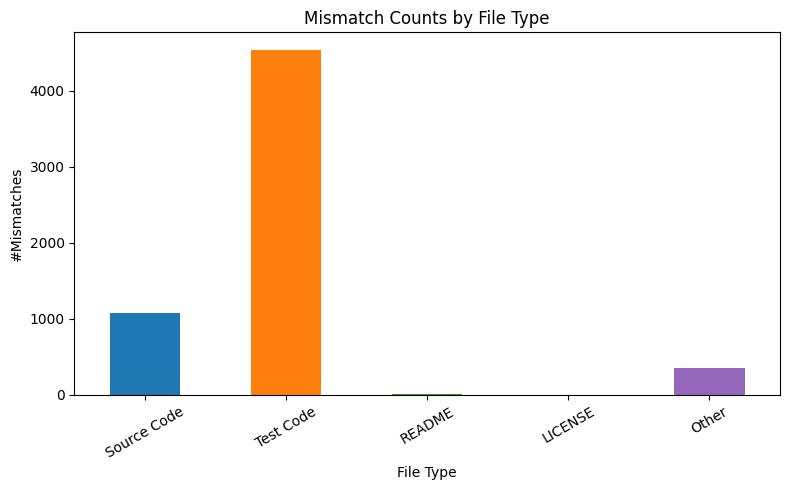

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

input_csv = "pydriller_dataset_with_discrepancy.csv"
df = pd.read_csv(input_csv)


def classify_file(row):
    path = str(row["new_file_path"] if pd.notna(row["new_file_path"]) else row["old_file_path"])
    path_lower = path.lower()

    if path == "nan" or path.strip() == "":
        return "Other"

    filename = os.path.basename(path)

    if filename.lower().startswith("readme"):
        return "README"
    if filename.lower().startswith("license"):
        return "LICENSE"
    if "test" in path_lower or "tests" in path_lower:
        return "Test Code"
    if filename.endswith((".py", ".c", ".cpp", ".java", ".js", ".ts", ".rb", ".go", ".rs")):
        return "Source Code"
    return "Other"


df["FileType"] = df.apply(classify_file, axis=1)


mismatches = df[df["Discrepancy"] == "Yes"]


counts = mismatches["FileType"].value_counts()


print("Mismatch Report:")
for category in ["Source Code", "Test Code", "README", "LICENSE", "Other"]:
    print(f"{category}: {counts.get(category, 0)}")


plt.figure(figsize=(8,5))
counts = counts.reindex(["Source Code", "Test Code", "README", "LICENSE", "Other"], fill_value=0)
counts.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])

plt.title("Mismatch Counts by File Type")
plt.xlabel("File Type")
plt.ylabel("#Mismatches")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
df.to_csv("pydriller_dataset_with_discrepancy_classified.csv", index=False)
